# **Stadium Attendance Prediction**

## **Data Processing**

In [ ]:
#Import necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import pickle
import shap
import sqlite3

In [ ]:
# we'll need this further to locate football.db
path  = "/content/drive/MyDrive/CS_project/Data/"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# we'll reuse this path further to locate football.db (our database)
path  = "/content/drive/MyDrive/CS_project/Data/"

In [ ]:
import sqlite3
import pandas as pd

# same path as before
path = "/content/drive/MyDrive/CS_project/Data/"
db_path = path + "football.db"

conn = sqlite3.connect(db_path)

query = """
SELECT
    -- Competition was constant in the original CSV
    'Jupiler Pro League'                    AS Competition,

    -- calendar / ids
    m.match_id                              AS match_id,
    m.matchday_label                        AS Matchday,
    m.match_date                            AS Date,
    CAST(m.time_hour AS FLOAT)              AS Time,

    -- teams & rankings
    t_home.team_name                        AS "Home Team",
    mp_home.ranking_at_match                AS "Ranking Home Team",
    t_away.team_name                        AS "Away Team",
    mp_away.ranking_at_match                AS "Ranking Away Team",

    -- attendance
    m.attendance                            AS Attendance,
    m.percentage_attendance                 AS PercentageAttendance,

    -- weather
    m.weather_type                          AS Weather,
    m.temperature_c                         AS "Temperature (°C)",
    m.weather_quality                       AS "Weather GoodBad",

    -- calendar details
    m.weekday                               AS Weekday,
    m.month                                 AS Month,
    CAST(strftime('%Y', m.match_date) AS INT) AS Year,
    m.season                                AS Season,
    -- quarter of the match date: 1..4
    CAST(((CAST(strftime('%m', m.match_date) AS INT) - 1) / 3 + 1) AS INT) AS quarter,
    m.day_of_month                          AS Day,
    m.game_day_type                         AS "Game day",
    m.time_slot                             AS "Time slot",
    m.derby_flag                            AS Derby,

    -- stadium
    s.stadium_name                          AS Stadium,
    CAST(s.max_capacity AS FLOAT)           AS "Max Capacity",
    s.city                                  AS City,
    s.province                              AS Province,
    CAST(s.full_roof AS FLOAT)              AS "Full Roof",

    -- macro context (already lagged in the CSV)
    ec.gdp_real_lagq                        AS GDP_Real_lagQ,
    ec.cpi_qoq_growth_pct_lagq              AS "CPI_QoQ_Growth_%_lagQ",
    ec.employment_rate_pct_lagq             AS "Employment_Rate_%_lagQ",

    -- goals & outcomes
    mp_home.goals_scored                    AS "Home Team Goals Scored",
    mp_away.goals_scored                    AS "Away Team Goals Scored",
    m.match_type                            AS "Match Type",
    mp_home.outcome                         AS "Home Team Outcome",
    mp_away.outcome                         AS "Away Team Outcome",

    -- rolling stats & categories (from the home team row)
    mp_home.goals_scored_last5              AS "Goals Scored in Last 5 Games",
    mp_home.goals_conceded_last5            AS "Goals Conceded in Last 5 Games",
    mp_home.wins_last5                      AS "Number of Wins in Last 5 Games",
    mp_home.opponent_category               AS "Opposing team Category",
    mp_home.team_category                   AS "Home team Category"

FROM Match AS m
JOIN Stadium AS s
    ON m.stadium_id = s.stadium_id
JOIN EconomicContext AS ec
    ON m.year    = ec.year
   AND m.quarter = ec.quarter
JOIN MatchParticipation AS mp_home
    ON m.match_id = mp_home.match_id
   AND mp_home.is_home = 1
JOIN Team AS t_home
    ON mp_home.team_id = t_home.team_id
JOIN MatchParticipation AS mp_away
    ON m.match_id = mp_away.match_id
   AND mp_away.is_home = 0
JOIN Team AS t_away
    ON mp_away.team_id = t_away.team_id
ORDER BY m.match_id;
"""

df = pd.read_sql_query(query, conn)
conn.close()


In [ ]:
### Test to see if the df is the same as the CleanedData

import numpy as np
import pandas as pd

# ORIGINAL CSV YOU USED BEFORE (adjust filename if needed)
csv_path = path + "CleanedData.csv"   # or "final_dataset.csv"
df_csv = pd.read_csv(csv_path)

print("CSV shape:", df_csv.shape)
print("DB  shape:", df.shape)

print("\nColumns only in DB:", sorted(set(df.columns) - set(df_csv.columns)))
print("Columns only in CSV:", sorted(set(df_csv.columns) - set(df.columns)))

# Align rows on a natural key
key_cols = ["Date", "Home Team", "Away Team"]
df_csv_sorted = df_csv.sort_values(key_cols).reset_index(drop=True)
df_db_sorted  = df.sort_values(key_cols).reset_index(drop=True)

common_cols = [c for c in df_csv.columns if c in df_db_sorted.columns]

# 1) numeric columns: max absolute difference
num_cols = df_csv_sorted[common_cols].select_dtypes(include=[np.number]).columns
print("\nNumeric column differences:")
for c in num_cols:
    diff = (df_csv_sorted[c] - df_db_sorted[c]).abs().max()
    print(f"  {c}: max |Δ| = {diff}")

# 2) object columns: count mismatches
obj_cols = df_csv_sorted[common_cols].select_dtypes(exclude=[np.number]).columns
print("\nCategorical column mismatches (row-wise):")
for c in obj_cols:
    mismatches = (df_csv_sorted[c] != df_db_sorted[c]).sum()
    print(f"  {c}: {mismatches} mismatches")


CSV shape: (1391, 40)
DB  shape: (1391, 41)

Columns only in DB: ['match_id']
Columns only in CSV: []

Numeric column differences:
  Time: max |Δ| = 0.0
  Ranking Home Team: max |Δ| = 0
  Ranking Away Team: max |Δ| = 0
  Attendance: max |Δ| = 0
  Temperature (°C): max |Δ| = 0.0
  Month: max |Δ| = 0
  Year: max |Δ| = 0
  quarter: max |Δ| = 0
  Max Capacity: max |Δ| = 0.0
  Full Roof: max |Δ| = 0.0
  PercentageAttendance: max |Δ| = 0.0
  GDP_Real_lagQ: max |Δ| = 0.0
  CPI_QoQ_Growth_%_lagQ: max |Δ| = 0.0
  Employment_Rate_%_lagQ: max |Δ| = 0.0
  Home Team Goals Scored: max |Δ| = 0
  Away Team Goals Scored: max |Δ| = 0
  Day: max |Δ| = 0
  Goals Scored in Last 5 Games: max |Δ| = 0.0
  Goals Conceded in Last 5 Games: max |Δ| = 0.0
  Number of Wins in Last 5 Games: max |Δ| = 0.0
  Derby: max |Δ| = 0

Categorical column mismatches (row-wise):
  Competition: 447 mismatches
  Matchday: 0 mismatches
  Home Team: 0 mismatches
  Away Team: 0 mismatches
  Weather: 0 mismatches
  Date: 0 mismatches

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1391 entries, 0 to 1390
Data columns (total 41 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Competition                     1391 non-null   object 
 1   match_id                        1391 non-null   int64  
 2   Matchday                        1391 non-null   object 
 3   Date                            1391 non-null   object 
 4   Time                            1391 non-null   float64
 5   Home Team                       1391 non-null   object 
 6   Ranking Home Team               1391 non-null   int64  
 7   Away Team                       1391 non-null   object 
 8   Ranking Away Team               1391 non-null   int64  
 9   Attendance                      1391 non-null   int64  
 10  PercentageAttendance            1391 non-null   float64
 11  Weather                         1391 non-null   object 
 12  Temperature (°C)                13

In [ ]:
df.head(10)

,Competition,match_id,Matchday,Date,Time,Home Team,Ranking Home Team,Away Team,Ranking Away Team,Attendance,...,Home Team Goals Scored,Away Team Goals Scored,Match Type,Home Team Outcome,Away Team Outcome,Goals Scored in Last 5 Games,Goals Conceded in Last 5 Games,Number of Wins in Last 5 Games,Opposing team Category,Home team Category
0,Jupiler Pro League,1,Final,2019-07-20,20.0,Genk,0,KV Mechelen,0,14160,...,3,0,Normal Time,Win,Loss,8.0,4.0,2.0,Not ranked,Not ranked
1,Jupiler Pro League,2,Second Round 1st leg,2019-07-25,20.0,KAA Gent,0,FC Viitorul,0,13398,...,6,3,Normal Time,Win,Loss,10.0,7.0,3.0,Not ranked,Not ranked
2,Jupiler Pro League,3,1,2019-07-26,20.0,Genk,7,KV Kortrijk,11,16120,...,2,1,Normal Time,Win,Loss,8.0,4.0,2.0,Bottom ranked,Medium ranked
3,Jupiler Pro League,4,1,2019-07-27,18.0,Cercle Brugge,14,Standard Liège,5,4311,...,0,2,Normal Time,Loss,Win,5.0,18.0,0.0,Medium ranked,Unknown
4,Jupiler Pro League,5,1,2019-07-27,20.0,Zulte Waregem,9,KV Mechelen,6,7033,...,0,2,Normal Time,Loss,Win,13.0,11.0,3.0,Medium ranked,Bottom ranked
5,Jupiler Pro League,6,1,2019-07-27,20.0,Sint-Truiden,12,Mouscron,10,4338,...,0,1,Normal Time,Loss,Win,3.0,11.0,0.0,Bottom ranked,Bottom ranked
6,Jupiler Pro League,7,1,2019-07-28,18.0,R Charleroi SC,3,KAA Gent,2,8760,...,1,1,Normal Time,Draw,Draw,8.0,10.0,1.0,Top ranked,Top ranked
7,Jupiler Pro League,8,1,2019-07-28,14.0,RSC Anderlecht,8,KV Oostende,15,19000,...,1,2,Normal Time,Loss,Win,10.0,5.0,4.0,Unknown,Medium ranked
8,Jupiler Pro League,9,2,2019-08-02,20.0,Club Brugge,2,Sint-Truiden,12,24600,...,6,0,Normal Time,Win,Loss,8.0,7.0,3.0,Bottom ranked,Top ranked
9,Jupiler Pro League,10,2,2019-08-03,18.0,Standard Liège,3,Zulte Waregem,14,25778,...,4,0,Normal Time,Win,Loss,11.0,7.0,4.0,Unknown,Top ranked


In [ ]:
# cap percentage Attendance to 1 and attendance to max Capacity
df['PercentageAttendance'] = df['PercentageAttendance'].clip(upper=1)
df['Attendance'] = np.minimum(df['Attendance'], df['Max Capacity'])


In [ ]:
# Group by  'Home Team' und calculate Percentiles for the Attendance for the Teams
team_stats = df.groupby('Home Team').agg(
    max_capacity=('Max Capacity', 'first'),  # MAx- Capacity for each team
    attendance_30th_percentile=('Attendance', lambda x: x.quantile(0.30)),  # 30. Percentile
    attendance_70th_percentile=('Attendance', lambda x: x.quantile(0.70))   # 70. percentile
).reset_index()

print(team_stats)

         Home Team  max_capacity  attendance_30th_percentile  \
0    Cercle Brugge       29062.0                      3890.4   
1      Club Brugge       29062.0                     19602.0   
2    FCV Dender EH        6200.0                      1008.0   
3             Genk       23500.0                     14243.8   
4         KAA Gent       20000.0                     11334.0   
5      KV Mechelen       16500.0                     10980.0   
6     KVC Westerlo        8000.0                      4500.0   
7      La Louvière       12000.0                      1888.0   
8        OH Leuven       10500.0                      5322.4   
9   R Charleroi SC       15000.0                      5965.7   
10  RSC Anderlecht       22500.0                     17602.4   
11   Royal Antwerp       16644.0                     12000.0   
12    Sint-Truiden       14600.0                      4337.2   
13  Standard Liège       27670.0                     16314.0   
14        Union SG        9400.0        

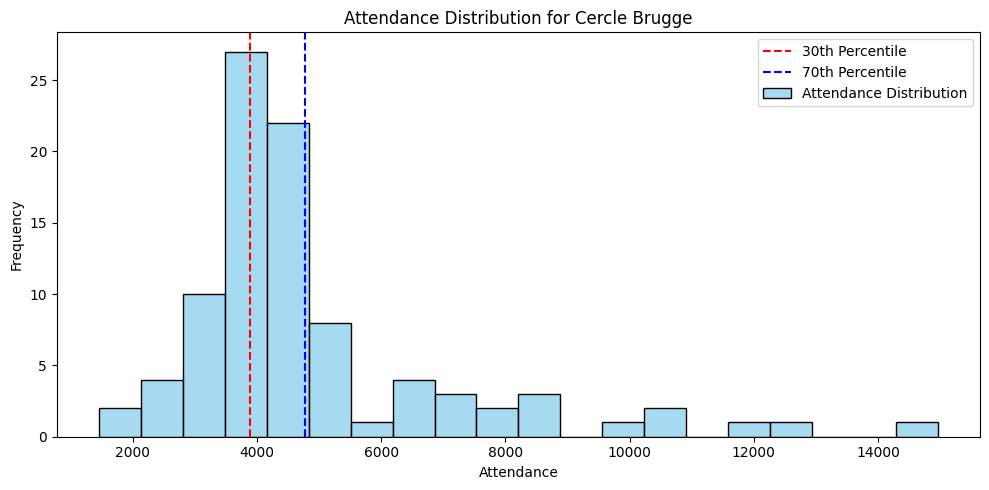

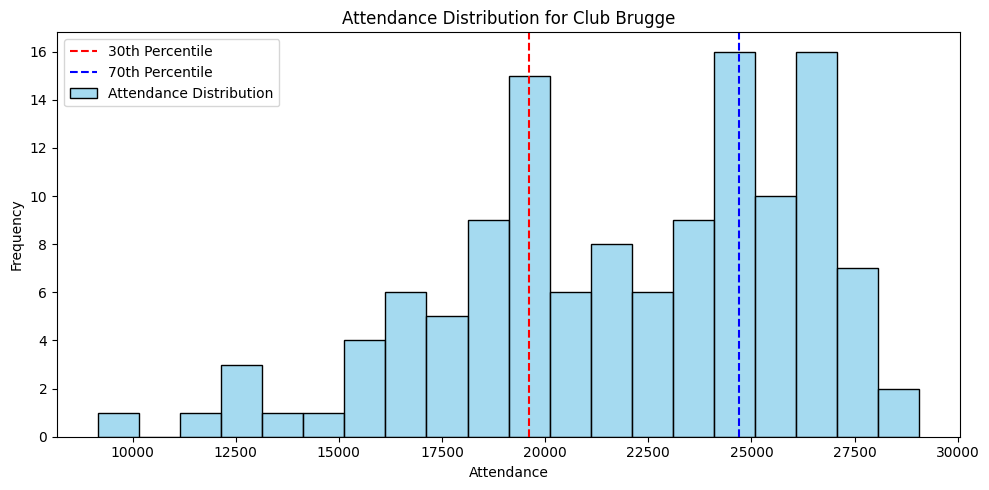

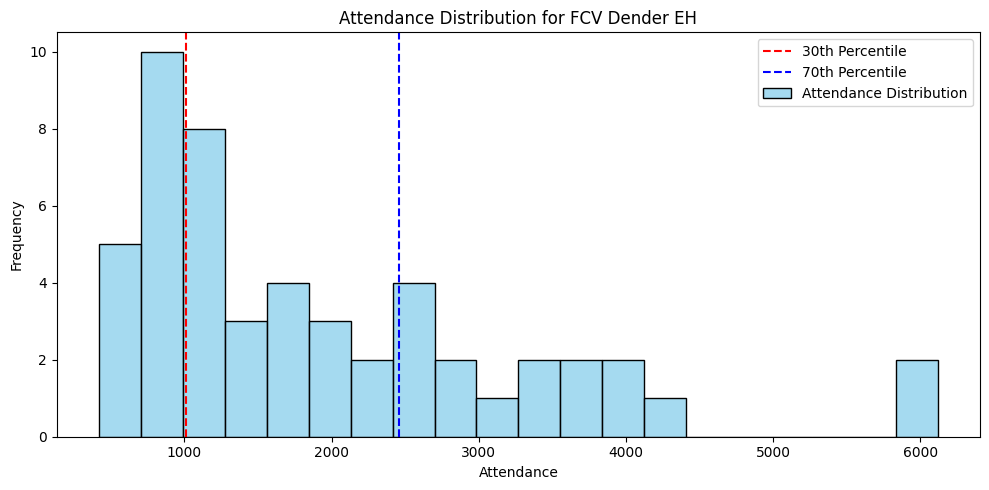

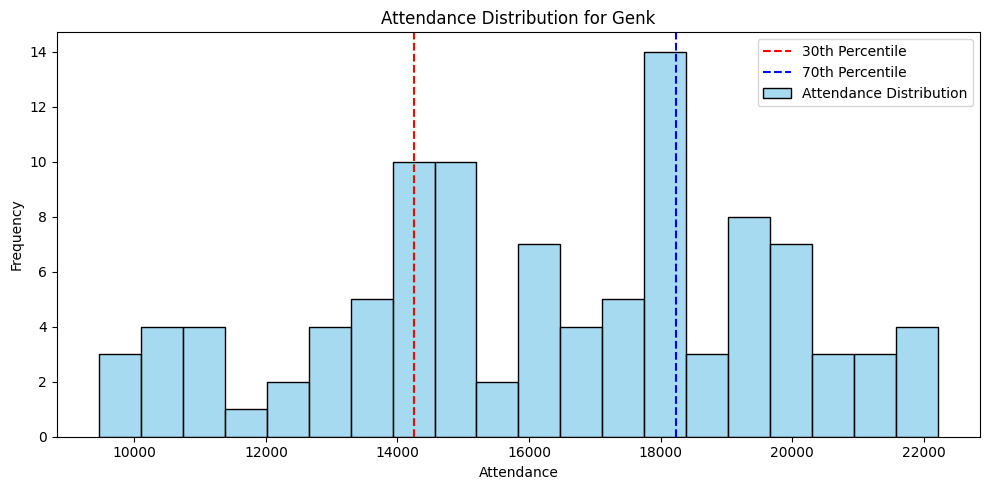

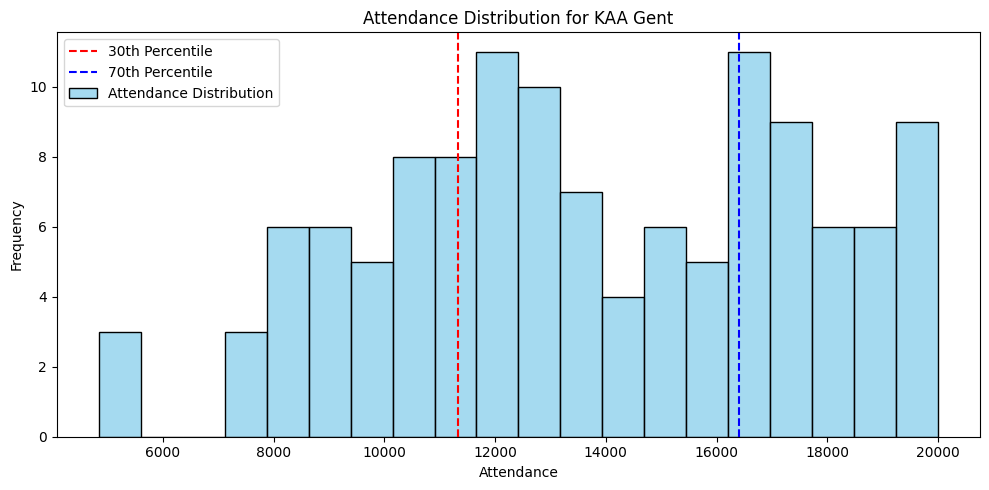

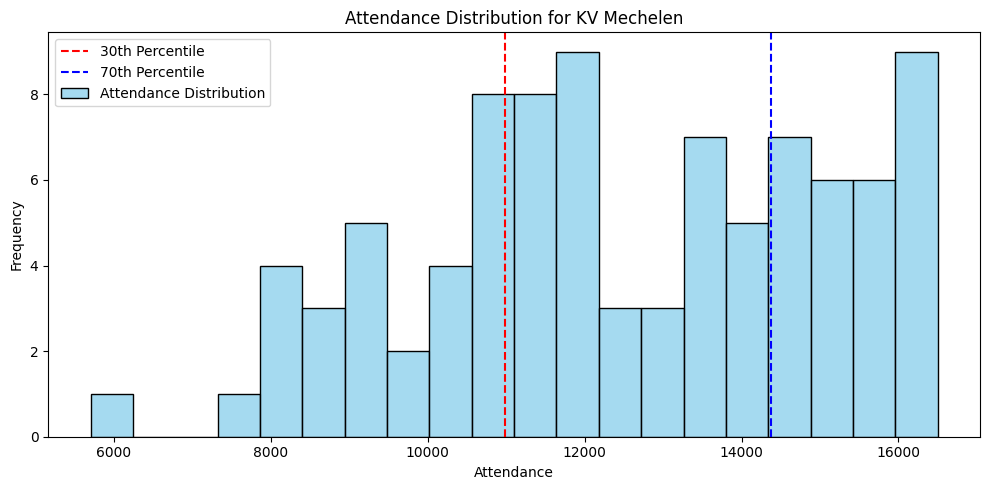

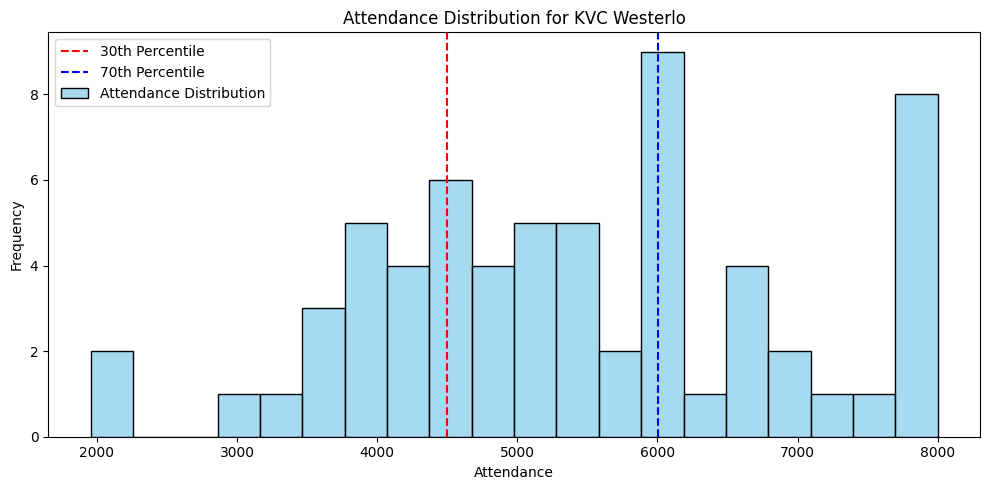

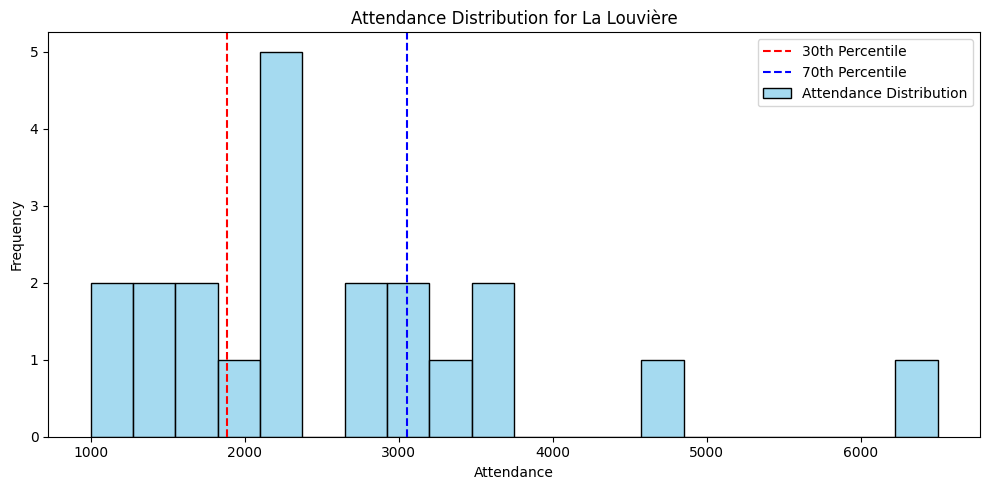

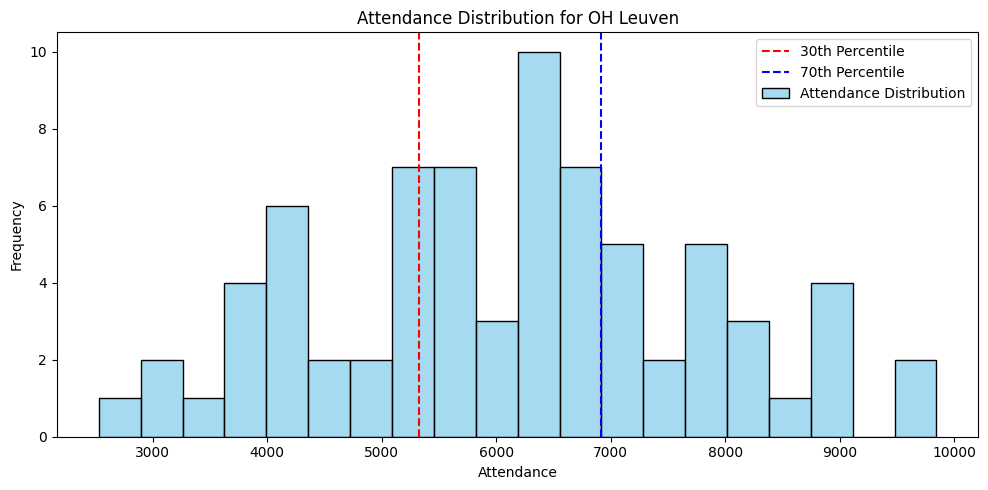

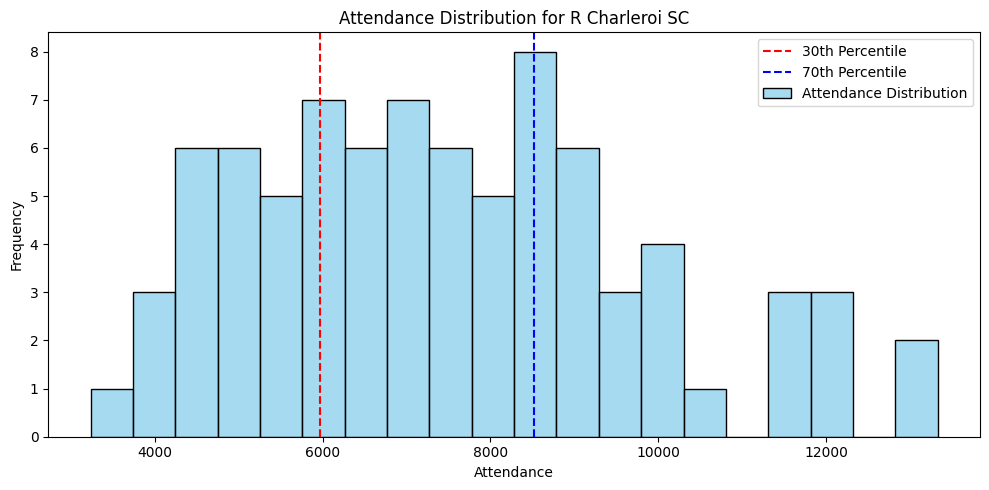

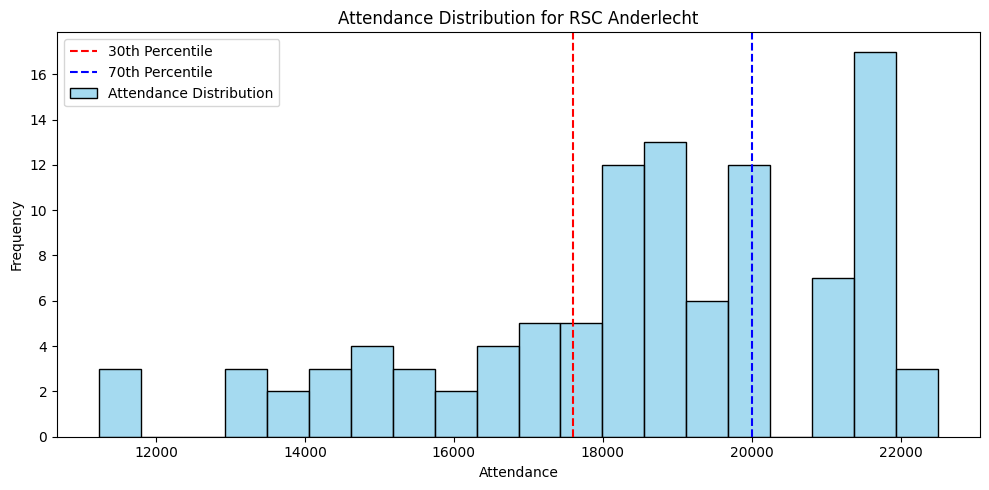

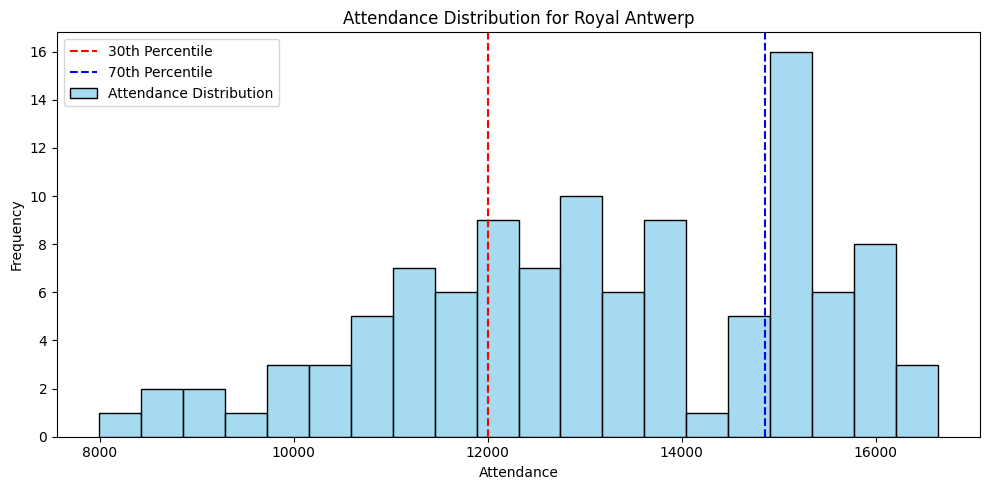

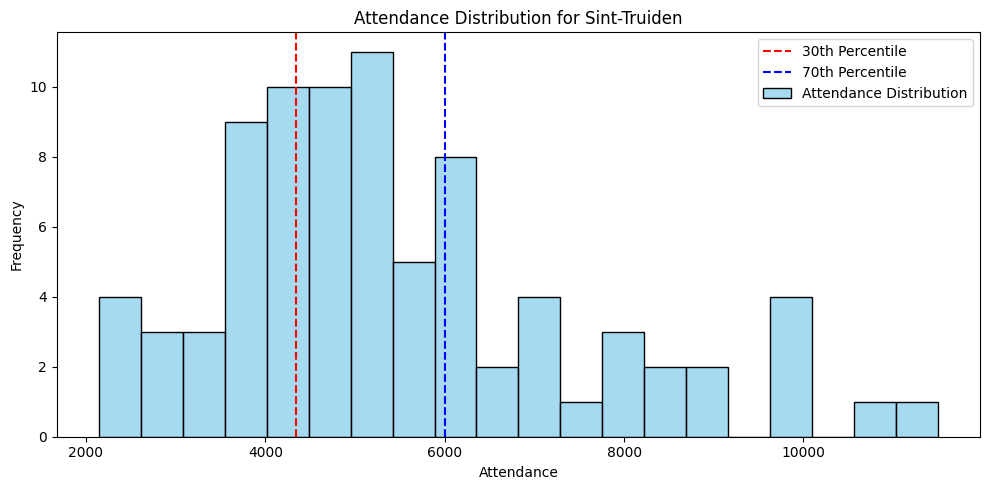

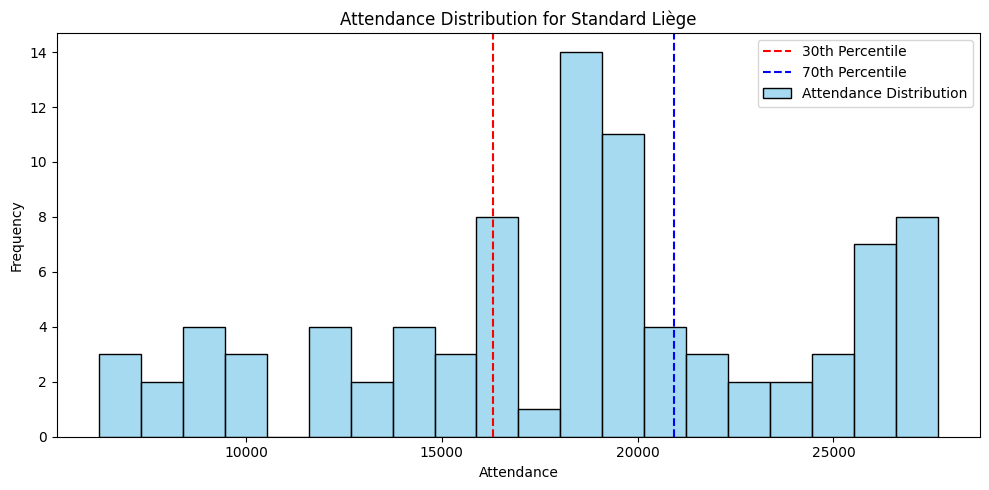

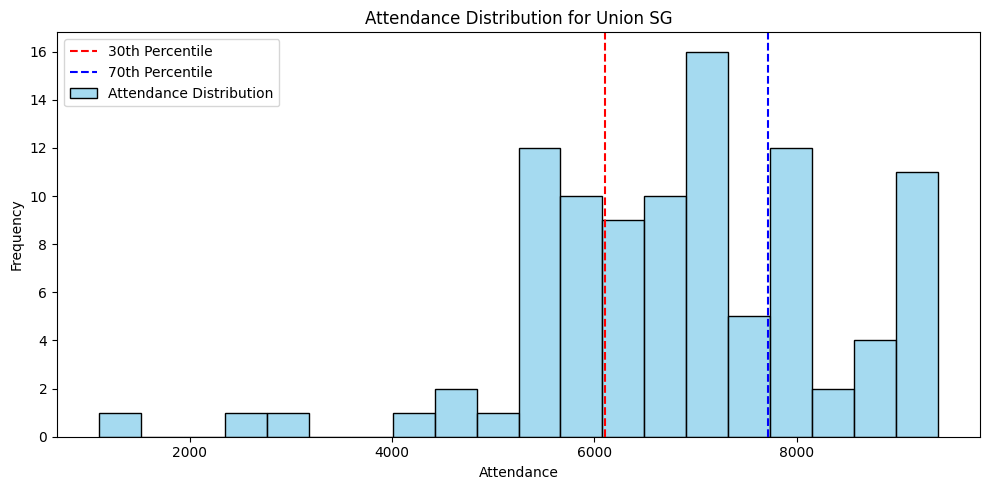

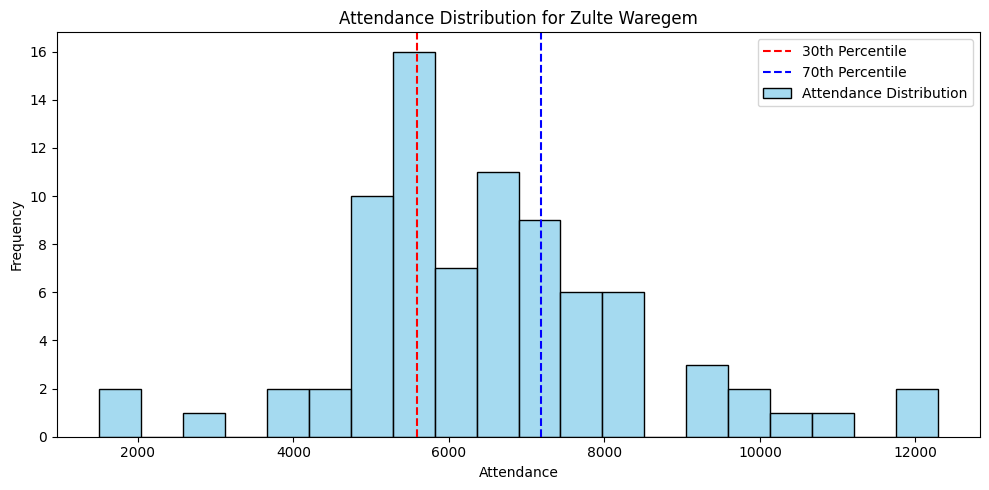

In [ ]:
# Iterate through the different Home teams to visualise the specific Attendance Distributions for the Home Teams
for team in team_stats['Home Team']:
    team_data = df[df['Home Team'] == team]  # Filter data for the specific team
    attendance_30th = team_stats.loc[team_stats['Home Team'] == team, 'attendance_30th_percentile'].values[0]
    attendance_70th = team_stats.loc[team_stats['Home Team'] == team, 'attendance_70th_percentile'].values[0]

    plt.figure(figsize=(10, 5))
    sns.histplot(team_data['Attendance'], kde=False, bins=20, color="skyblue", label="Attendance Distribution")
    plt.axvline(attendance_30th, color='red', linestyle='--', label='30th Percentile')
    plt.axvline(attendance_70th, color='blue', linestyle='--', label='70th Percentile')
    plt.title(f"Attendance Distribution for {team}")
    plt.xlabel("Attendance")
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.show()

### Multicolinearity Check

In [ ]:
# ======================================================
#   VIF — clean, self-contained, robust version
# ======================================================

import pandas as pd
import numpy as np
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1) Define target & make a working copy
TARGET = "PercentageAttendance"
df_model = df.drop(columns=[TARGET], errors="ignore").copy()

# 2) Encode categorical cols safely
cat_cols = [
    "Matchday","Home Team","Away Team","Weekday",
    "Opposing team Category","Home team Category",
    "Game day","Time slot","Weather GoodBad","Weather"
]
df_model = pd.get_dummies(df_model, columns=cat_cols, drop_first=True)

# 3) Keep only numeric columns
df_model = df_model.select_dtypes(include=[np.number])

# 4) Coerce remaining weird stuff & fill NA
df_model = df_model.apply(pd.to_numeric, errors='coerce').fillna(0)

# 5) Add constant
X = add_constant(df_model)

# 6) Compute VIF
vif_df = pd.DataFrame({
    "Feature": X.columns,
    "VIF": [
        variance_inflation_factor(X.values, i)
        for i in range(X.shape[1])
    ]
}).sort_values("VIF", ascending=False)

vif_df


,Feature,VIF
0,const,5.409511e+07
8,Year,4.206170e+01
9,quarter,2.731380e+01
7,Month,2.601196e+01
14,GDP_Real_lagQ,2.429674e+01
1,match_id,1.911748e+01
16,Employment_Rate_%_lagQ,4.615061e+00
21,Number of Wins in Last 5 Games,3.113210e+00
19,Goals Scored in Last 5 Games,2.412019e+00
5,Attendance,2.025961e+00


---
**Analysis**

Based on the VIF table shows how strongly each feature is correlated with the other features in the csv. So a high VIF means that the feature doesn't bring any additional information and is redundant with other features.

This can cause problems or ML models and notably linear ones.

We can see in this VIF table that const (the intercept) is extremly high, however this does not represent an issue.

quarter, Year, Month and GDP_real_lagQ all have VIF values above 20. Which can be problematic.

Therefore we decide to Drop Year and Quarter. But to still keep month as a measure of annually seasonal pieces of information and GDP_Real_lagQ as an economic measure that "month" cannot help with.

-------

In [ ]:
df = df.drop(columns=["Year", "quarter"], errors="ignore")

In [ ]:
# ========== RECOMPUTE VIF TABLE (after dropping Year & quarter) ==========

import numpy as np
import pandas as pd
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

TARGET = "PercentageAttendance"

# 1) Copy df and remove target
df_model = df.drop(columns=[TARGET], errors="ignore").copy()

# 2) One-hot encode categoricals
cat_cols = [
    "Matchday","Home Team","Away Team","Weekday",
    "Opposing team Category","Home team Category",
    "Game day","Time slot","Weather GoodBad","Weather"
]
df_model = pd.get_dummies(df_model, columns=cat_cols, drop_first=True)

# 3) Keep numerics only, coerce and fill NaN
df_model = df_model.select_dtypes(include=[np.number]).apply(pd.to_numeric, errors="coerce").fillna(0)

# 4) Add constant
X = add_constant(df_model)

# 5) Compute VIF
vif_df = pd.DataFrame({
    "Feature": X.columns,
    "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
}).sort_values("VIF", ascending=False)

vif_df


,Feature,VIF
0,const,59513.810928
12,GDP_Real_lagQ,11.966603
1,match_id,10.891972
14,Employment_Rate_%_lagQ,4.360129
19,Number of Wins in Last 5 Games,3.111840
17,Goals Scored in Last 5 Games,2.408877
5,Attendance,2.017269
10,Max Capacity,1.749496
18,Goals Conceded in Last 5 Games,1.691893
3,Ranking Home Team,1.597794


-----
We now see that there is no multicolinearity left

----


In [ ]:
# We now remove teams that are not part of the 16 current jupiler league teams to avoid the creation of many dummy with almost no information that woud explode the number of columns. SO we put them all under the same box "unknown"
super_league_teams = [
    'Club Brugge', 'Cercle Brugge', 'Genk', 'RSC Anderlecht', 'Union SG', 'KAA Gent', 'Royal Antwerp', 'KVC Westerlo', 'Standard Liège', 'KV Mechelen', 'R Charleroi SC', 'OH Leuven', "Sint-Truiden", "FCV Dender EH", "Zulte Waregem", "La Louvière"
]

# Put all other teams as 'Unknown'
df['Away Team'] = df['Away Team'].apply(lambda team: team if team in super_league_teams else 'Unknown')

In [ ]:
# Identification of categorial columns
categorical_columns = [
    "Matchday",
    "Home Team",
    "Away Team",
    "Weekday"
]

# Dummy-Encoding
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

In [ ]:
# Identification of categorial columns, where complete Dummy-Codierung is used for easier Feature Importance Analysis later

categorial_columns_2 = [
    "Opposing team Category",
    "Home team Category",
    "Game day",
    "Time slot",
    "Weather GoodBad",
    "Weather",
]

df = pd.get_dummies(df, columns=categorial_columns_2, drop_first=False)

In [ ]:
df = df.apply(pd.to_numeric, errors='ignore')

/tmp/ipython-input-1277559549.py:1: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


In [ ]:
# checking how many ranks = 0
# Count rows with 0 in Home/Away ranking
home_zero = (df['Ranking Home Team'] == 0)
away_zero = (df['Ranking Away Team'] == 0)
either_zero = home_zero | away_zero

print("Rows with 0 in either ranking:", either_zero.sum())
print("  ├─ 0 in Ranking Home Team:", home_zero.sum())
print("  └─ 0 in Ranking Away Team:", away_zero.sum())

# (Optional) see the first few offending rows
display(df.loc[either_zero].head())


Rows with 0 in either ranking: 209
  ├─ 0 in Ranking Home Team: 209
  └─ 0 in Ranking Away Team: 209


,Competition,match_id,Date,Time,Ranking Home Team,Ranking Away Team,Attendance,PercentageAttendance,Temperature (°C),Month,...,Time slot_Afternoon,Time slot_Evening,Time slot_Night,Weather GoodBad_Bad,Weather GoodBad_Good,Weather_Clear or mostly clear,Weather_Drizzle,Weather_Partly cloudy,Weather_Rainy,Weather_Snowy
0,Jupiler Pro League,1,2019-07-20,20.0,0,0,14160.0,0.602553,22.5,7,...,False,False,True,False,True,True,False,False,False,False
1,Jupiler Pro League,2,2019-07-25,20.0,0,0,13398.0,0.669900,33.9,7,...,False,False,True,False,True,False,False,True,False,False
14,Jupiler Pro League,15,2019-08-06,20.0,0,0,27018.0,0.929668,20.7,8,...,False,False,True,True,False,False,True,False,False,False
15,Jupiler Pro League,16,2019-08-08,19.0,0,0,15734.0,0.945326,23.5,8,...,False,True,False,False,True,False,False,True,False,False
22,Jupiler Pro League,23,2019-08-15,20.0,0,0,18700.0,0.935000,19.0,8,...,False,False,True,False,True,False,False,True,False,False


In [ ]:
# Drop rows where either ranking is 0
mask_bad = (df['Ranking Home Team'] == 0) | (df['Ranking Away Team'] == 0)
n_bad = int(mask_bad.sum())

df = df.loc[~mask_bad].copy()
df.reset_index(drop=True, inplace=True)

print(f"Dropped {n_bad} rows with 0 in rankings. New shape: {df.shape}")
print("Any 0s left?",
      (df['Ranking Home Team'] == 0).any() or (df['Ranking Away Team'] == 0).any())


Dropped 209 rows with 0 in rankings. New shape: (1182, 149)
Any 0s left? False


In [ ]:
## Lastly we add a column match_id to simplify our life for the ERM that we will create afterwards.

df["match_id"] = range(1, len(df) + 1)
df.head()


,Competition,match_id,Date,Time,Ranking Home Team,Ranking Away Team,Attendance,PercentageAttendance,Temperature (°C),Month,...,Time slot_Afternoon,Time slot_Evening,Time slot_Night,Weather GoodBad_Bad,Weather GoodBad_Good,Weather_Clear or mostly clear,Weather_Drizzle,Weather_Partly cloudy,Weather_Rainy,Weather_Snowy
0,Jupiler Pro League,1,2019-07-26,20.0,7,11,16120.0,0.685957,30.0,7,...,False,False,True,False,True,False,False,True,False,False
1,Jupiler Pro League,2,2019-07-27,18.0,14,5,4311.0,0.148338,18.9,7,...,False,True,False,True,False,False,True,False,False,False
2,Jupiler Pro League,3,2019-07-27,20.0,9,6,7033.0,0.567177,18.7,7,...,False,False,True,True,False,False,True,False,False,False
3,Jupiler Pro League,4,2019-07-27,20.0,12,10,4338.0,0.297123,19.4,7,...,False,False,True,True,False,False,False,False,True,False
4,Jupiler Pro League,5,2019-07-28,18.0,3,2,8760.0,0.584000,19.4,7,...,False,True,False,True,False,False,True,False,False,False


## **Data Exploration**

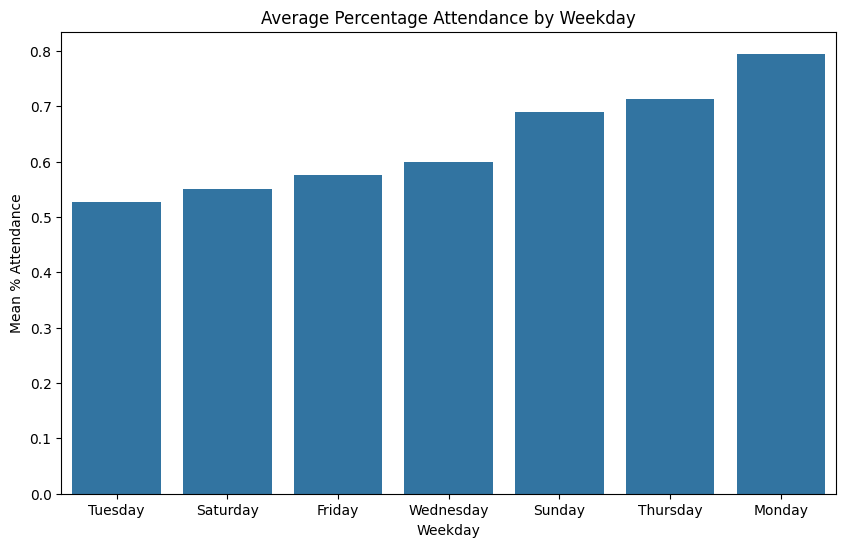

In [ ]:
# --- reload clean data JUST for plotting, do NOT overwrite df ---
df_plot = pd.read_csv(path + "CleanedData.csv")

plt.figure(figsize=(10,6))
mean_att = (
    df_plot.groupby("Weekday")["PercentageAttendance"]
    .mean()
    .sort_values()
)

sns.barplot(x=mean_att.index, y=mean_att.values)
plt.title("Average Percentage Attendance by Weekday")
plt.ylabel("Mean % Attendance")
plt.show()


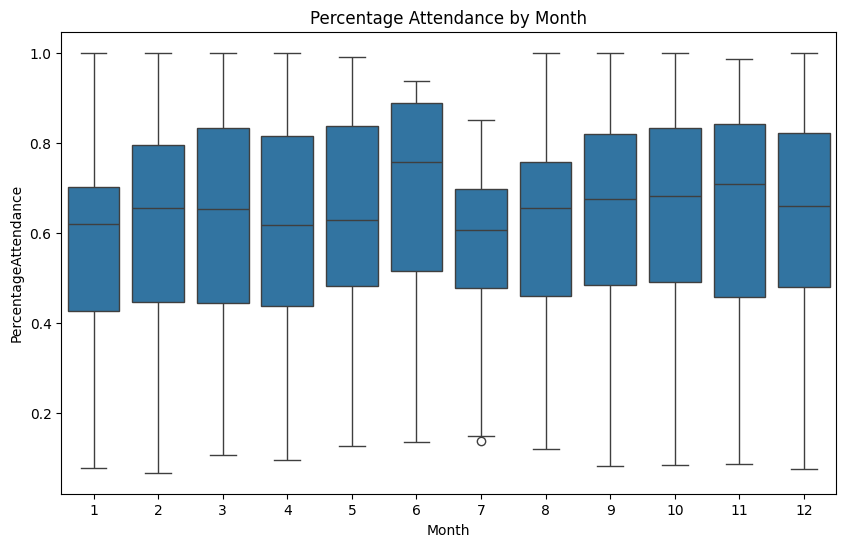

In [ ]:
##Influence of the Month on percentage Attendance
plt.figure(figsize=(10, 6))
sns.boxplot(x='Month', y='PercentageAttendance', data=df)
plt.title("Percentage Attendance by Month")
plt.show()

----

Higher medians in spring and late autumn (≈ Mar–May and Oct–Nov). Distributions are tighter too → more consistently high attendance.

Dip in early summer (≈ Jun–Jul): lower medians and lower upper whiskers → fewer sell-outs, more variability.

Winter (Jan–Feb, Dec) looks middling: medians around ~0.6–0.7 with wider spread.

Outliers (very low % games) pop up mainly around Aug–Oct and Dec—likely weather-affected matches, awkward kick-off times, or low-draw fixtures.

Why this might happen:

Fixture importance rises toward the run-in (Apr–May) and again in autumn after the season settles.

Summer break/holidays and friendlies/qualifiers can depress club attendance in Jun–Jul.

Weather & holidays (cold snaps, Xmas period) add variance in winter months.

---

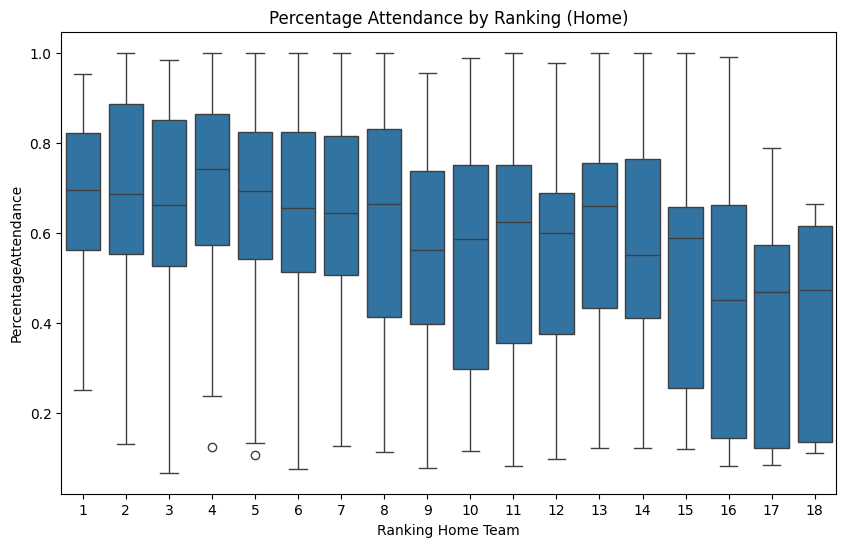

In [ ]:
#Influence of Home Team Ranking on percentage Attendance
plt.figure(figsize=(10, 6))
sns.boxplot(x='Ranking Home Team', y='PercentageAttendance', data=df)
plt.title("Percentage Attendance by Ranking (Home)")
plt.show()

---

Clear downward trend: As the home team’s rank number increases (team is worse), the median percentage attendance steps down. Ranks 1–5 sit around the highest medians (~0.7–0.8), while 15–18 drop notably (~0.45–0.6).

Spread widens for weaker teams: From about rank 10 onward, the boxes get taller and the lower whiskers/outliers dip more. That means weaker home teams not only draw less on average, they’re less consistent—more very low-attendance games.

Ceiling persists across ranks: The top whiskers touch ~1.0 almost everywhere. So even poorly ranked teams can sell out on the right night (derbies, marquee opponents, decisive fixtures).

Kinks rather than perfectly linear: It’s not a smooth slope—there’s a fairly flat plateau around ranks ~5–9, then a sharper drop after ~12–13, and the steepest fall sits in the 15–18 range.

Takeaways

Home team quality is a strong driver of turnout (in percentage terms, so capacity isn’t the culprit).

Variability grows as quality drops → planning risk is higher for lower-ranked teams.

Big-match effects can override rank, producing near-sellouts at any rank.

---

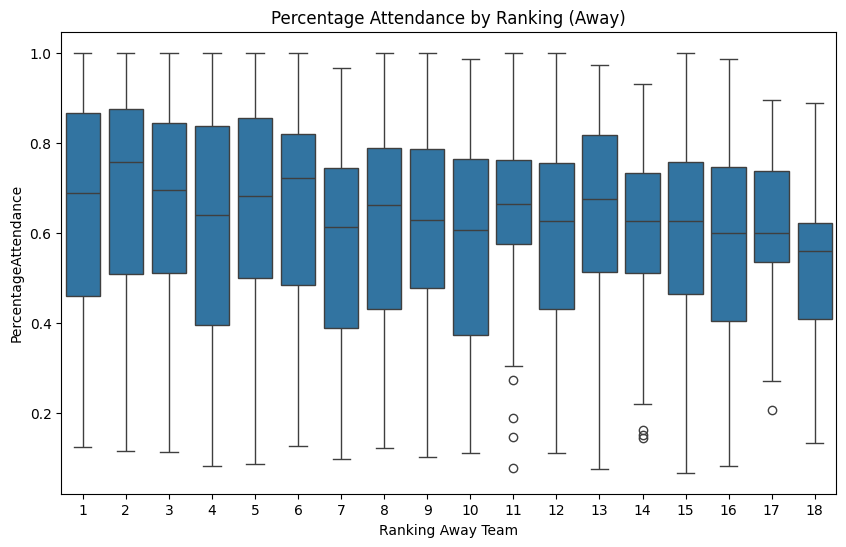

In [ ]:
#Influence of Away Team Ranking on percentage Attendance
plt.figure(figsize=(10, 6))
sns.boxplot(x='Ranking Away Team', y='PercentageAttendance', data=df)
plt.title("Percentage Attendance by Ranking (Away)")
plt.show()

---

Mild downward trend: Better away teams (rank 1–4) tend to draw slightly higher median attendance (~0.70–0.80). As the away rank number increases (weaker team), the median drifts down toward ~0.55–0.65 by ranks 15–18. So away quality matters—but only moderately.

Bigger spread for weaker visitors: From about ranks 10–18 the boxes widen and low-end whiskers/outliers dip more. That means “bad” away teams produce more volatile turnouts—some nights okay, some very poor.

High ceiling across all ranks: Upper whiskers touch ~1.0 for most ranks. Even weak visitors can fill the place when other factors are favorable (derbies, decisive fixtures, weekends, good weather, strong home side).

Nonlinear shape: It’s not a straight line—there’s a plateau around mid-table and sharper drops at the bottom ranks. Encode rank with bins/splines or treat as categorical rather than purely linear.

Likely confounders: Capacity capping (percentage capped at 1), home-team strength, derby flag, kickoff time/day, and competition stage can all override away rank.

---

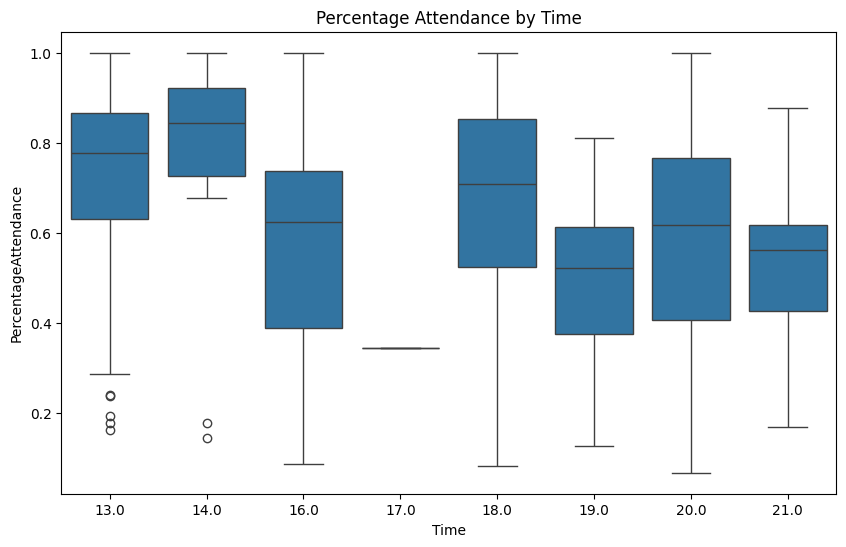

In [ ]:
#Influence of Time on percentage Attendance
plt.figure(figsize=(10, 6))
sns.boxplot(x='Time', y='PercentageAttendance', data=df)
plt.title("Percentage Attendance by Time")
plt.show()

---

Best turnout: 13:00–14:00 have the highest medians (~0.8–0.9) and relatively tight boxes → reliably strong crowds.

OK: 18:00–20:00 sit in the middle (medians ~0.65–0.75) with more spread → decent but less consistent.

Weaker: 19:00 and 21:00 look lower (~0.55–0.6) and more variable → more nights with half-full stands.

Risky slot: 16:00 shows wide variance and very low outliers (~0.1) → occasionally poor attendance.

Ceiling effect: Upper whiskers touch 1.0 across times, so sell-outs can still happen at any slot (derbies, big opponents, etc.).

---

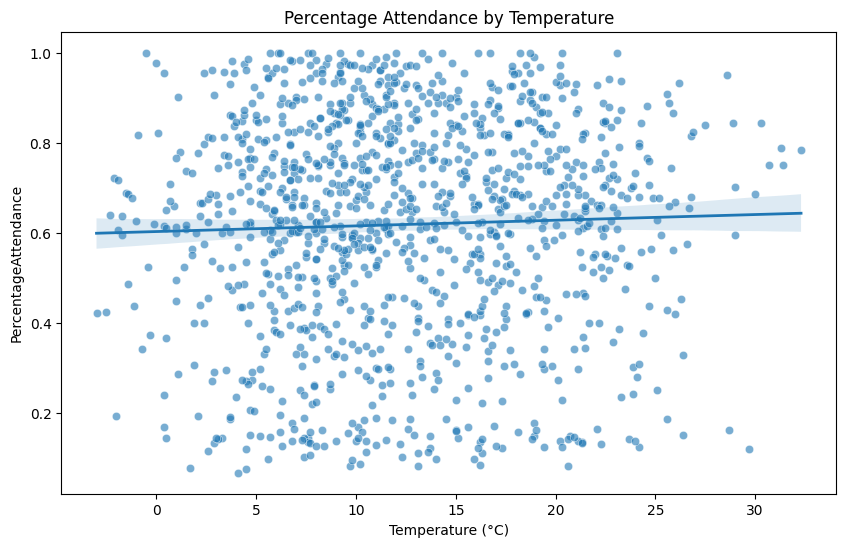

In [ ]:
#Influence of Temperature on percentage Attendance
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(x='Temperature (°C)', y='PercentageAttendance', data=df, alpha=0.6)

# add linear trendline (with 95% CI band)
sns.regplot(
    x='Temperature (°C)', y='PercentageAttendance', data=df,
    scatter=False, ci=95, ax=ax, line_kws={'linewidth': 2}
)

plt.title("Percentage Attendance by Temperature")
plt.show()


---

The cloud of points is very wide at every temperature and the trendline is almost flat with a tiny positive slope → very weak association.

So moving from, say, 5 °C to 25 °C barely shifts expected attendance percentage.

Temperature alone won’t be a good predictor; other factors (team quality, derby/importance, day/time, capacity, rain/snow) likely dominate.

---

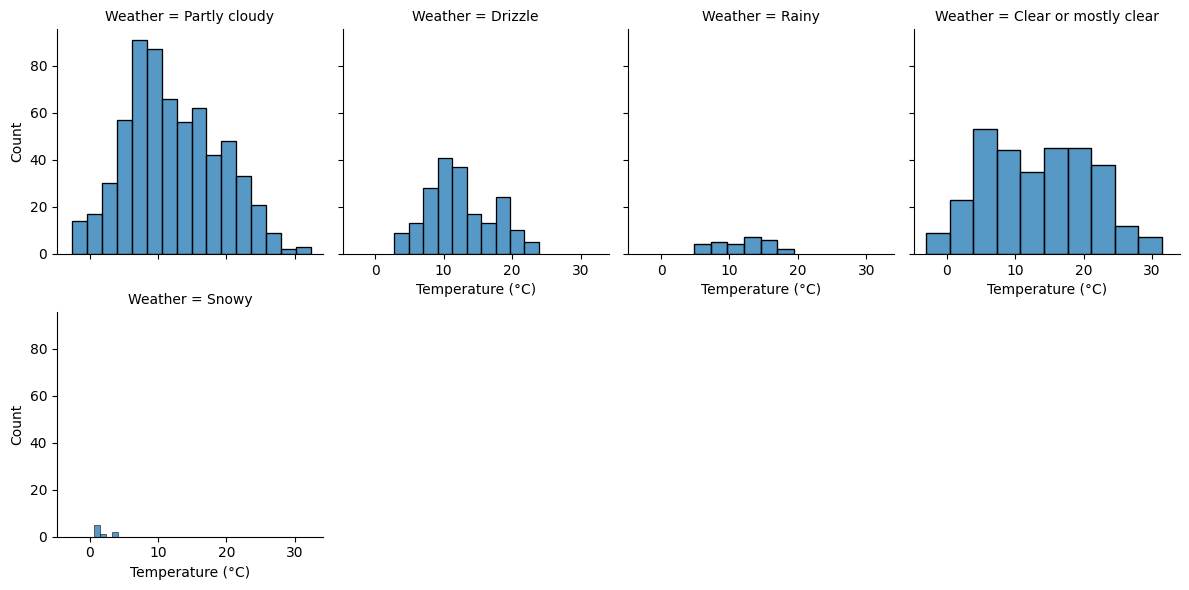

In [ ]:
# Build a temporary Series called weather_label from either the original column
# or from one-hot encoded columns that start with 'Weather_'.
if 'Weather' in df.columns:
    weather_label = df['Weather']
else:
    weather_cols = [c for c in df.columns if c.startswith('Weather_')]
    # If you also have "Weather GoodBad" dummies, keep them out:
    weather_cols = [c for c in weather_cols if c != 'Weather_GoodBad']
    # Recover the label from the one-hot columns
    weather_label = (
        df[weather_cols]
        .idxmax(axis=1)                       # e.g., 'Weather_Rainy'
        .str.replace('Weather_', '', regex=False)  # -> 'Rainy'
        .fillna('Unknown')
    )

# Make a small plotting dataframe (does not touch df)
plot_df = pd.DataFrame({
    'Weather': weather_label.values,
    'Temperature (°C)': df['Temperature (°C)'].values
})

# Your facet plot
g = sns.FacetGrid(plot_df, col="Weather", col_wrap=4)
g.map(sns.histplot, "Temperature (°C)")
plt.show()


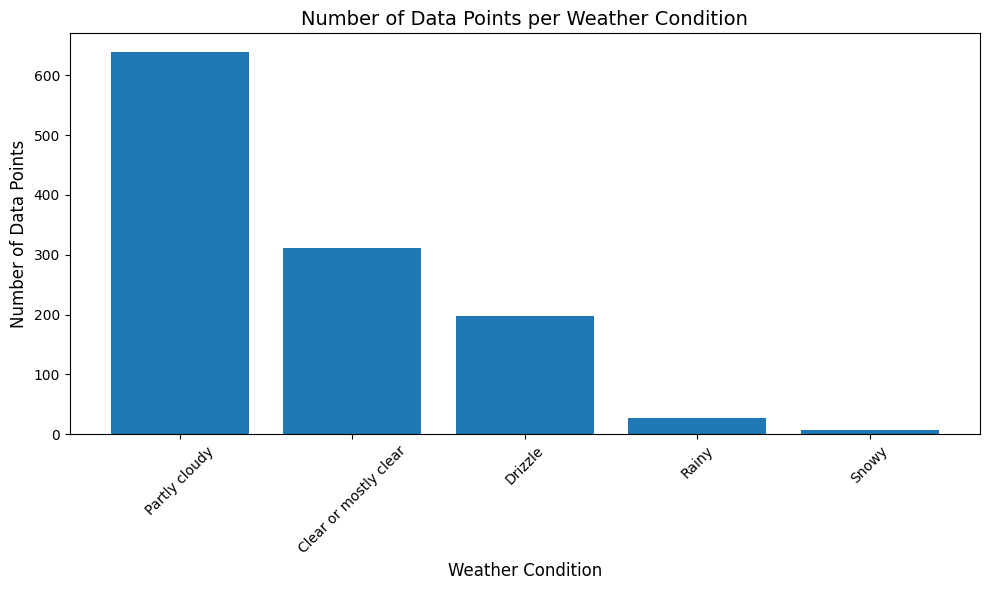

In [ ]:
# Count number of Datapoints per Weather Condition
weather_conditions = [ 'Weather_Clear or mostly clear','Weather_Partly cloudy',
                      'Weather_Rainy', 'Weather_Drizzle', 'Weather_Snowy']

#Count number of Data Points for each weather condition
weather_counts = {weather.split('_')[-1]: df[weather].sum() for weather in weather_conditions}

#convert to Dataframe
weather_counts_df = pd.DataFrame(list(weather_counts.items()), columns=['Weather Condition', 'Count'])

# Sort
weather_counts_df = weather_counts_df.sort_values(by='Count', ascending=False)

# Visualize
plt.figure(figsize=(10, 6))
plt.bar(weather_counts_df['Weather Condition'], weather_counts_df['Count'])
plt.xlabel('Weather Condition', fontsize=12)
plt.ylabel('Number of Data Points', fontsize=12)
plt.title('Number of Data Points per Weather Condition', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

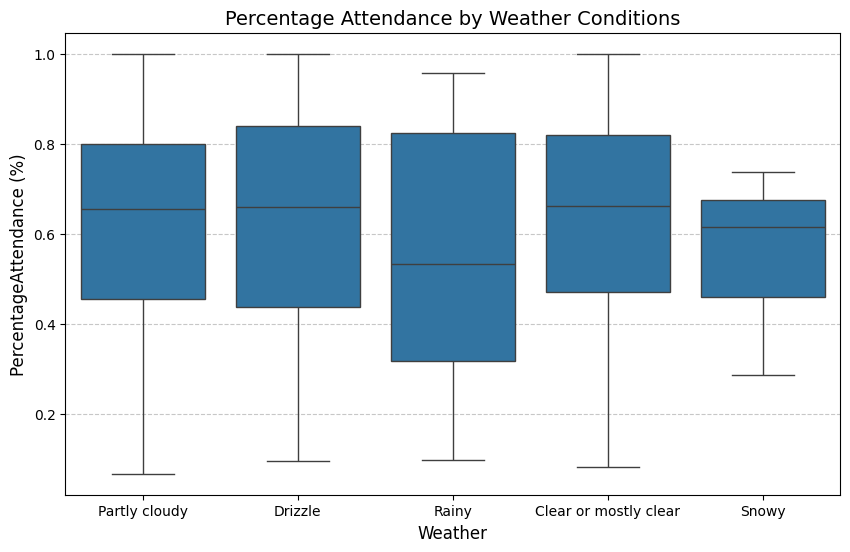

In [ ]:
# Recreate a categorical Weather label from one-hot columns
weather_cols = [c for c in df.columns if c.startswith('Weather_') and c != 'Weather_GoodBad']
weather_label = (
    df[weather_cols]
    .idxmax(axis=1)              # e.g. 'Weather_Rainy'
    .str.replace('Weather_', '', regex=False)
    .fillna('Unknown')
)

plot_df = pd.DataFrame({
    'Weather': weather_label,
    'PercentageAttendance': df['PercentageAttendance']
})

plt.figure(figsize=(10, 6))
sns.boxplot(x='Weather', y='PercentageAttendance', data=plot_df)
plt.title('Percentage Attendance by Weather Conditions', fontsize=14)
plt.xlabel('Weather', fontsize=12)
plt.ylabel('PercentageAttendance (%)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


---

As could have been expected the average percent attendance drops on rainy and snowy days with even a compressed volatility, highlighting the effect.

---

## **Saving the Data**

In [ ]:
path_to_save = "/content/final_dataset.csv"
df.to_csv(path_to_save, index=False)

# Will be used for our ERM and the data that will feed our Models
from google.colab import files
files.download(path_to_save)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **We then create a database (on another ipynb) and load it**

Our ERD:
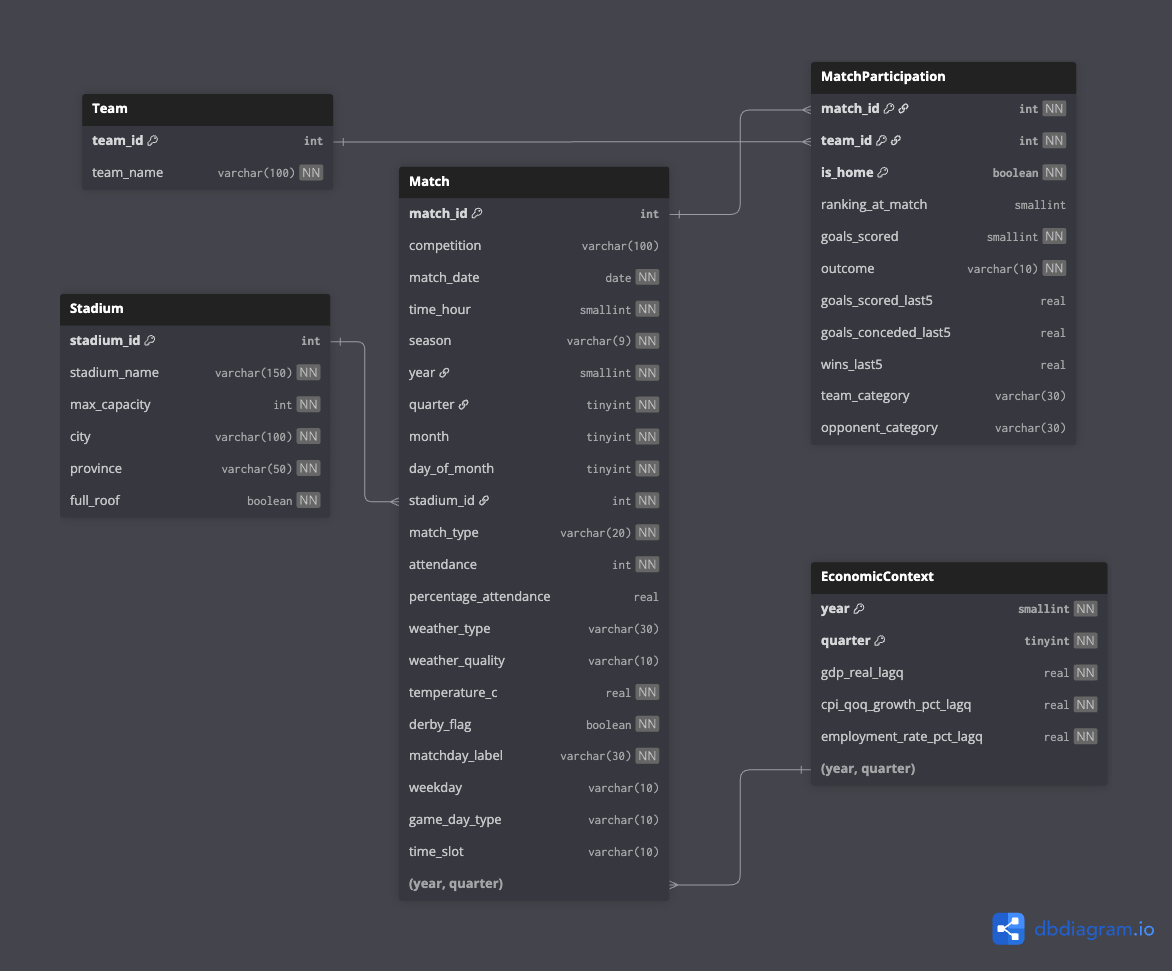

## **Model**

In [ ]:
# Drop the raw Attendance column from the dataset (keep PercentageAttendance as target)
if 'Attendance' in df.columns:
    df = df.drop(columns=['Attendance'])
    print("Dropped column: Attendance")
else:
    print("Column 'Attendance' not found; nothing to drop.")


Column 'Attendance' not found; nothing to drop.


In [ ]:
target = "PercentageAttendance"

# keep only numeric + bool predictors, then cast everything to float
X_weather_num = (
    df.drop(columns=[target])
      .select_dtypes(include=['number', 'bool'])
      .astype(float)          # 🔑 this avoids the statsmodels object-dtype error
)

y_weather = df[target].astype(float)

from sklearn.model_selection import train_test_split

X_train_weather, X_test_weather, y_train_weather, y_test_weather = train_test_split(
    X_weather_num, y_weather, test_size=0.25, random_state=42
)

import statsmodels.api as sm

X_train_linreg_weather = sm.add_constant(X_train_weather)
linreg_weather = sm.OLS(y_train_weather, X_train_linreg_weather).fit()


In [ ]:
X_train_weather

,match_id,Time,Ranking Home Team,Ranking Away Team,Temperature (°C),Month,Day,Derby,Max Capacity,Full Roof,...,Time slot_Afternoon,Time slot_Evening,Time slot_Night,Weather GoodBad_Bad,Weather GoodBad_Good,Weather_Clear or mostly clear,Weather_Drizzle,Weather_Partly cloudy,Weather_Rainy,Weather_Snowy
66,67.0,18.0,8.0,9.0,16.9,10.0,26.0,0.0,15000.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
67,68.0,20.0,7.0,13.0,19.1,10.0,26.0,0.0,12400.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
333,334.0,20.0,4.0,2.0,18.2,5.0,21.0,0.0,16500.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
211,212.0,21.0,7.0,17.0,7.5,11.0,7.0,0.0,23500.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
12,13.0,20.0,2.0,4.0,22.2,8.0,9.0,0.0,8000.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1044,1045.0,18.0,1.0,11.0,-1.7,1.0,11.0,0.0,23500.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1095,1096.0,13.0,2.0,7.0,11.5,2.0,23.0,0.0,29062.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1130,1131.0,16.0,2.0,4.0,15.6,4.0,5.0,0.0,29062.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
860,861.0,20.0,6.0,3.0,8.1,4.0,25.0,0.0,16644.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
#Function to save the results of the different models in a dataframe for easier comparison / visualization

#Dataframe
results = pd.DataFrame(columns=["Model", "MSE", "RMSE", "R2"])

def evaluate_model(model_name, y_test, y_pred, results_df):

    #Calculation of metrics
    mse_value = mean_squared_error(y_test, y_pred)
    rmse_value = np.sqrt(mse_value)
    r2_value = r2_score(y_test, y_pred)

    # Add results to the Dataframe
    results_df = pd.concat([
        results_df,
        pd.DataFrame({
            "Model": [model_name],
            "MSE": [mse_value],
            "RMSE": [rmse_value],
            "R2": [r2_value]
        })
    ], ignore_index=True)

    return results_df

### Linear Regression

#### Linear Regression with Weather

In [ ]:
#Add constant to the Trainingsset
X_train_linreg_weather = sm.add_constant(X_train_weather)

#Create Model and Fit
linreg_weather = sm.OLS(y_train_weather, X_train_linreg_weather).fit()

In [ ]:
#Add Constant to the Testset
X_test_linreg_weather = sm.add_constant(X_test_weather)

#Make Prediction
y_pred_linreg_weather = linreg_weather.predict(X_test_linreg_weather)

In [ ]:
#Save rsults to the Dataframe
results = evaluate_model("Linear Regression (weather)", y_test_weather, y_pred_linreg_weather, results)

#### Linear Regression without Weather

In [ ]:
# Drop weather-related columns
weather_cols = [
    c for c in df.columns
    if c.startswith('Weather_')              # detailed weather dummies
    or c.startswith('Weather GoodBad_')      # Good/Bad dummies
    or c in ('WeatherGoodBad', 'Weather GoodBad')  # raw col, just in case
]

df_without_weather = df.drop(columns=weather_cols, errors='ignore')

# Define target and features for the model without weather
target = "PercentageAttendance"

X_without_weather = (
    df_without_weather
        .drop(columns=[target])
        .select_dtypes(include=['number', 'bool'])  # keep numeric + bool
        .astype(float)                              # turn bools into 0.0/1.0
)

y_without_weather = df_without_weather[target].astype(float)

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split

X_train_without_weather, X_test_without_weather, y_train_without_weather, y_test_without_weather = train_test_split(
    X_without_weather, y_without_weather, test_size=0.25, random_state=42
)


In [ ]:
# 1) Build test design matrix to match training features
feat_cols = [c for c in model.model.exog_names if c != "const"]   # columns used in training

X_test = (
    X_test_without_weather
      .select_dtypes(include=[np.number])      # numeric only
      .replace([np.inf, -np.inf], np.nan)
      .reindex(columns=feat_cols, fill_value=0)  # align to training cols
)
X_test = sm.add_constant(X_test, has_constant='add')

# 2) Predict
y_pred_linreg_without_weather = model.predict(X_test)


In [ ]:
#Save rsults to the Dataframe
results = evaluate_model("Linear Regression (without weather)", y_test_without_weather, y_pred_linreg_without_weather, results)

#### Log Linear Regression with Weather

In [ ]:
eps = 1e-6
y_log = np.log(y_train_weather.clip(eps, None))
X_tr = sm.add_constant(X_train_weather, has_constant='add')
log_lin = sm.OLS(y_log, X_tr).fit()

X_te = sm.add_constant(X_test_weather, has_constant='add')
log_pred = log_lin.predict(X_te)

# Duan smearing
smear = np.mean(np.exp(log_lin.resid))
y_pred_log_linreg_weather = np.exp(log_pred) * smear


In [ ]:
#Save rsults to the Dataframe
results = evaluate_model("Log Linear Regression (weather)", y_test_weather, y_pred_log_linreg_weather, results)

#### Log Linear Regression without weather

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# 1) TRAIN matrix — numeric only, clean infs/NaNs, and **drop any target-ish cols**
X_tr = X_train_without_weather.select_dtypes(include=[np.number]).replace([np.inf, -np.inf], np.nan)

# prevent leakage from any attendance-related columns that might have slipped in
possible_target_names = {'Attendance', 'PercentageAttendance'}
if hasattr(y_train_without_weather, 'name') and y_train_without_weather.name:
    possible_target_names.add(y_train_without_weather.name)
leaky_cols = [c for c in X_tr.columns if c in possible_target_names or c.lower().startswith('attendance')]
X_tr = X_tr.drop(columns=leaky_cols, errors='ignore')

# handle NaNs (drop or impute — here we drop for simplicity)
X_tr = X_tr.drop(columns=X_tr.columns[X_tr.isna().any()])

# y numeric & aligned
y_tr = pd.to_numeric(y_train_without_weather, errors='coerce')
mask = y_tr.notna()
X_tr, y_tr = X_tr.loc[mask], y_tr.loc[mask]

# 2) Logit-transform the target safely
eps = 1e-6
y_tr_clip = y_tr.clip(eps, 1 - eps)
y_tr_logit = np.log(y_tr_clip / (1 - y_tr_clip))

# 3) Add intercept and fit
X_tr = sm.add_constant(X_tr, has_constant='add')
logit_linreg_wo_weather = sm.OLS(y_tr_logit, X_tr, missing='drop').fit()

# 4) TEST matrix — **same columns as training**
feat_cols = [c for c in logit_linreg_wo_weather.model.exog_names if c != "const"]
X_te = (X_test_without_weather
        .select_dtypes(include=[np.number])
        .replace([np.inf, -np.inf], np.nan)
        .reindex(columns=feat_cols, fill_value=0))
X_te = sm.add_constant(X_te, has_constant='add')

# 5) Predict and inverse-logit back to (0,1), with tiny clip for safety
y_pred_logit_wo_weather = logit_linreg_wo_weather.predict(X_te)
y_pred_log_linreg_without_weather = 1 / (1 + np.exp(-y_pred_logit_wo_weather))
y_pred_log_linreg_without_weather = np.clip(y_pred_log_linreg_without_weather, eps, 1 - eps)

# (optional) paranoia check
assert not any(c in logit_linreg_wo_weather.model.exog_names for c in ['Attendance', 'PercentageAttendance']), \
    "Target leaked into design matrix!"


In [ ]:
#Save rsults to the Dataframe
results = evaluate_model("Log Linear Regression (without weather)", y_test_without_weather, y_pred_log_linreg_without_weather, results)

###Tree Based Models

#### Random Forest

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer

def run_rf(
    X_train, X_test, y_train, y_test,
    label, results_df,
    n_estimators=100, max_depth=6, random_state=42,
    impute="drop"  # "drop" (drop cols with NaNs) or "median" (impute)
):
    # --- numeric-only + clean infs ---
    X_tr = X_train.select_dtypes(include=[np.number]).replace([np.inf, -np.inf], np.nan).copy()
    X_te = X_test.select_dtypes(include=[np.number]).replace([np.inf, -np.inf], np.nan).copy()

    # --- prevent target leakage ---
    possible_target_names = {'Attendance', 'PercentageAttendance'}
    if hasattr(y_train, 'name') and y_train.name:
        possible_target_names.add(y_train.name)
    leaky_cols = [c for c in X_tr.columns if c in possible_target_names or c.lower().startswith('attendance')]
    X_tr.drop(columns=leaky_cols, errors='ignore', inplace=True)
    X_te.drop(columns=leaky_cols, errors='ignore', inplace=True)

    # --- handle NaNs (choose one approach) ---
    if impute == "median":
        imp = SimpleImputer(strategy="median")
        X_tr = pd.DataFrame(imp.fit_transform(X_tr), columns=X_tr.columns, index=X_tr.index)
        X_te = pd.DataFrame(imp.transform(X_te.reindex(columns=X_tr.columns)), columns=X_tr.columns, index=X_te.index)
    else:  # drop columns with any NaN
        bad_cols = X_tr.columns[X_tr.isna().any()]
        X_tr = X_tr.drop(columns=bad_cols)
        X_te = X_te.reindex(columns=X_tr.columns, fill_value=0)

    # --- target numeric & aligned ---
    y_tr = pd.to_numeric(y_train, errors='coerce')
    mask = y_tr.notna()
    X_tr, y_tr = X_tr.loc[mask], y_tr.loc[mask]

    # --- fit & predict ---
    rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
    rf.fit(X_tr, y_tr)
    y_pred = rf.predict(X_te)

    # --- log results ---
    results_df = evaluate_model(f"Random Forest ({label})", y_test, y_pred, results_df)
    return y_pred, results_df, rf

# ---------- Run it for both variants ----------
# Choose impute="median" if you want to keep all columns; "drop" is stricter.
_yp_w, results, rf_with_weather = run_rf(
    X_train_weather, X_test_weather, y_train_weather, y_test_weather,
    label="weather", results_df=results, impute="median"
)

_yp_wo, results, rf_without_weather = run_rf(
    X_train_without_weather, X_test_without_weather, y_train_without_weather, y_test_without_weather,
    label="without weather", results_df=results, impute="median"
)


In [ ]:
#Save rsults to the Dataframe
results = evaluate_model("Random Forest (weather)", y_test_weather, _yp_w, results)

In [ ]:
#Save rsults to the Dataframe
results = evaluate_model("Random Forest (without weather)", y_test_without_weather, _yp_wo, results)

#### XGBoost

In [ ]:
from scipy.stats import randint, uniform, loguniform
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

# X and y are your numeric feature matrix and target in [0,1]
xgb_base = XGBRegressor(
    objective="reg:squarederror",
    tree_method="hist",        # fast & good default
    random_state=42
)

param_dist_wide = {
    # go both lower/faster and higher/slower than your current best
    "n_estimators": randint(300, 1200),
    # try smaller lrs with more trees and a bit larger too
    "learning_rate": loguniform(0.01, 0.2),   # ~0.01–0.2
    "max_depth": randint(3, 9),               # 3–8
    "min_child_weight": randint(1, 11),       # 1–10
    "subsample": uniform(0.5, 0.5),           # 0.5–1.0
    "colsample_bytree": uniform(0.5, 0.5),    # 0.5–1.0

    # add regularization & split penalty
    "gamma": uniform(0.0, 5.0),               # 0–5
    "reg_alpha": loguniform(1e-4, 1e0),       # L1: 1e-4–1
    "reg_lambda": loguniform(1e-2, 1e1),      # L2: 1e-2–10
}

rs1 = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist_wide,
    n_iter=60,                # bump a bit for the bigger space
    scoring="neg_mean_squared_error",
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

rs1.fit(X_train_weather, y_train_weather)
best1 = rs1.best_estimator_
print("Stage-1 best:", rs1.best_params_)


Fitting 3 folds for each of 60 candidates, totalling 180 fits
Stage-1 best: {'colsample_bytree': np.float64(0.8238450602706812), 'gamma': np.float64(0.002601884976579094), 'learning_rate': np.float64(0.028754290605607913), 'max_depth': 5, 'min_child_weight': 7, 'n_estimators': 1009, 'reg_alpha': np.float64(0.01104051190316225), 'reg_lambda': np.float64(0.1787446325623842), 'subsample': np.float64(0.6110539052353652)}


In [ ]:
from scipy.stats import uniform, loguniform, randint

best = rs1.best_params_

def clipped_uniform_01(center, halfwidth, lo_floor=0.5):
    lo = max(lo_floor, center - halfwidth)
    hi = min(1.0, center + halfwidth)
    # ensure positive scale
    return uniform(loc=lo, scale=max(1e-9, hi - lo))

param_dist_narrow = {
    "n_estimators": randint(int(best["n_estimators"]*0.6), int(best["n_estimators"]*1.6)),
    "learning_rate": loguniform(max(best["learning_rate"]/2, 1e-4), min(best["learning_rate"]*2, 3e-1)),
    "max_depth": randint(max(3, best["max_depth"]-2), min(10, best["max_depth"]+3)),
    "min_child_weight": randint(max(1, best["min_child_weight"]-3), best["min_child_weight"]+4),

    # ⬇️ CLIPPED distributions in [0, 1]
    "subsample": clipped_uniform_01(best["subsample"], 0.2),          # ~ ±0.2 around best, clipped
    "colsample_bytree": clipped_uniform_01(best["colsample_bytree"], 0.2),

    # the rest are already valid
    "gamma": uniform(max(0.0, best.get("gamma", 0.0) - 1.0), 2.0),
    "reg_alpha": loguniform(max(1e-6, best.get("reg_alpha", 1e-3)/10),
                            max(1e-2, best.get("reg_alpha", 1e-3)*10)),
    "reg_lambda": loguniform(max(1e-4, best.get("reg_lambda", 1.0)/10),
                             max(1e2,  best.get("reg_lambda", 1.0)*10)),
}


rs2 = RandomizedSearchCV(
    estimator=XGBRegressor(objective="reg:squarederror", tree_method="hist", random_state=42),
    param_distributions=param_dist_narrow,
    n_iter=40,
    scoring="neg_mean_squared_error",
    cv=3,
    verbose=1,
    random_state=43,
    n_jobs=-1
)

rs2.fit(X_train_weather, y_train_weather)
best_xgb_weather = rs2.best_estimator_
print("Stage-2 best:", rs2.best_params_)


Fitting 3 folds for each of 40 candidates, totalling 120 fits
Stage-2 best: {'colsample_bytree': np.float64(0.9644349207029682), 'gamma': np.float64(0.032051835864237876), 'learning_rate': np.float64(0.03231175040567319), 'max_depth': 3, 'min_child_weight': 8, 'n_estimators': 1224, 'reg_alpha': np.float64(0.012262653109848818), 'reg_lambda': np.float64(20.235223749189114), 'subsample': np.float64(0.6854898359812263)}


In [ ]:
#Save rsults to the Dataframe
results = evaluate_model("XGBoost (weather)", y_test_weather, best_xgb_weather.predict(X_test_weather), results)

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import randint, uniform, loguniform
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

# --- Build TRAIN matrix (numeric-only, handle inf/NaN), drop target-ish cols ---
Xtr = (X_train_without_weather
       .select_dtypes(include=[np.number])
       .replace([np.inf, -np.inf], np.nan))     # keep NaNs (XGB can handle them)

possible_target_names = {'Attendance', 'PercentageAttendance'}
if hasattr(y_train_without_weather, 'name') and y_train_without_weather.name:
    possible_target_names.add(y_train_without_weather.name)
leaky = [c for c in Xtr.columns if c in possible_target_names or c.lower().startswith('attendance')]
Xtr = Xtr.drop(columns=leaky, errors='ignore')

# Target numeric + align rows (drop rows where y is NaN)
ytr = pd.to_numeric(y_train_without_weather, errors='coerce')
mask = ytr.notna()
Xtr, ytr = Xtr.loc[mask], ytr.loc[mask]

# --- Model + search space ---
xgb_wo = XGBRegressor(objective="reg:squarederror", tree_method="hist", random_state=42)

param_dist = {
    "n_estimators": randint(300, 1200),
    "learning_rate": loguniform(1e-3, 2e-1),
    "max_depth": randint(3, 10),
    "min_child_weight": randint(1, 11),
    "subsample": uniform(0.5, 0.5),          # 0.5–1.0
    "colsample_bytree": uniform(0.5, 0.5),   # 0.5–1.0
    "gamma": uniform(0.0, 5.0),
    "reg_alpha": loguniform(1e-4, 1.0),
    "reg_lambda": loguniform(1e-2, 1e1),
}

rs = RandomizedSearchCV(
    estimator=xgb_wo,
    param_distributions=param_dist,
    n_iter=60,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)
rs.fit(Xtr, ytr)
best_xgb_without_weather = rs.best_estimator_
print("Best params (without weather):", rs.best_params_)

# --- Predict on TEST (align columns to training; keep NaNs) ---
feat_cols = Xtr.columns
Xte = (X_test_without_weather
       .select_dtypes(include=[np.number])
       .replace([np.inf, -np.inf], np.nan)
       .reindex(columns=feat_cols, fill_value=np.nan))

y_pred_wo = best_xgb_without_weather.predict(Xte)

Fitting 3 folds for each of 60 candidates, totalling 180 fits
Best params (without weather): {'colsample_bytree': np.float64(0.8238450602706812), 'gamma': np.float64(0.002601884976579094), 'learning_rate': np.float64(0.006475473254542376), 'max_depth': 5, 'min_child_weight': 7, 'n_estimators': 1009, 'reg_alpha': np.float64(0.01104051190316225), 'reg_lambda': np.float64(0.1787446325623842), 'subsample': np.float64(0.6110539052353652)}


In [ ]:
results = evaluate_model("XGBoost (without weather)", y_test_without_weather, y_pred_wo, results)

In [ ]:
results

,Model,MSE,RMSE,R2
0,Linear Regression (weather),0.013899,0.117895,0.767783
1,Linear Regression (without weather),0.047993,0.219073,0.198173
2,Log Linear Regression (weather),0.017197,0.131138,0.712683
3,Log Linear Regression (without weather),0.054922,0.234355,0.082408
4,Random Forest (weather),0.016012,0.126539,0.732481
5,Random Forest (without weather),0.020109,0.141806,0.664039
6,Random Forest (weather),0.016012,0.126539,0.732481
7,Random Forest (without weather),0.020109,0.141806,0.664039
8,XGBoost (weather),0.011549,0.107465,0.807055
9,XGBoost (without weather),0.018579,0.136304,0.689604


---
**Linear Regression**
Both versions (with and without weather data) give decent results, but there’s no real gain from adding weather. In fact, the simpler version (without weather) does slightly better which suggests linear models can’t really make use of the extra information.

**Log-Linear Regression**
Transforming the target doesn’t improve. The results are basically the same as standard linear regression, just a bit worse overall.

**Random Forest**
The model handles non-linear patterns better, and performance improves compared to linear models. But again, weather doesn’t change much, and the version without weather actually edges out the one with it. So the gain here comes from the model itself, not the extra feature.

**XGBoost**
This is the clear winner. It delivers the strongest predictions whether weather is included or not. The difference between the two versions is minimal which reinforces the same pattern: the feature isn’t very useful, but the model is.

## **Saving Model and Feature Analysis**

In [ ]:
# Save model excl. weather, to implement in Streamlit
filename = 'finalized_model_without_weather.sav'
pickle.dump(best_xgb_without_weather, open(path + filename, 'wb'))

In [ ]:
#Save model incl. weather, to implement in Streamlit
filename = 'finalized_model_with_weather.sav'
pickle.dump(best_xgb_weather, open(path + filename, 'wb'))

###Feature Analysis

In [ ]:
import shap
import numpy as np
import pandas as pd

# 1. Compute SHAP values for the final model (with weather, or switch to without if you prefer)
# Use a smaller background dataset for performance
background_data = X_train_weather.sample(100, random_state=42)

# Wrap the model's predict method
def predict_func(X):
    return best_xgb_weather.predict(X)

explainer = shap.Explainer(predict_func, shap.maskers.Independent(background_data))
shap_values = explainer(X_train_weather)

# 2. Convert to DataFrame
shap_df = pd.DataFrame(shap_values.values, columns=X_train_weather.columns)

# 3. Rank features by mean absolute SHAP value
shap_importance = shap_df.abs().mean().sort_values(ascending=False)

# 4. Display top features
shap_importance

PermutationExplainer explainer: 887it [04:26,  3.20it/s]


,0
Max Capacity,0.111118
Home Team_Club Brugge,0.036747
Away Team_Unknown,0.029992
CPI_QoQ_Growth_%_lagQ,0.016400
match_id,0.014808
...,...
Time slot_Night,0.000000
Weather GoodBad_Good,0.000000
Weather_Drizzle,0.000000
Weather_Rainy,0.000000


In [ ]:
expected_columns = list(X_train_without_weather.columns)

print("expected_columns = [")
for c in expected_columns:
    print(f"    '{c}',")
print("]")


expected_columns = [
    'match_id',
    'Time',
    'Ranking Home Team',
    'Ranking Away Team',
    'Temperature (°C)',
    'Month',
    'Day',
    'Derby',
    'Max Capacity',
    'Full Roof',
    'GDP_Real_lagQ',
    'CPI_QoQ_Growth_%_lagQ',
    'Employment_Rate_%_lagQ',
    'Home Team Goals Scored',
    'Away Team Goals Scored',
    'Goals Scored in Last 5 Games',
    'Goals Conceded in Last 5 Games',
    'Number of Wins in Last 5 Games',
    'Matchday_10',
    'Matchday_11',
    'Matchday_12',
    'Matchday_13',
    'Matchday_14',
    'Matchday_15',
    'Matchday_16',
    'Matchday_17',
    'Matchday_18',
    'Matchday_19',
    'Matchday_2',
    'Matchday_20',
    'Matchday_21',
    'Matchday_22',
    'Matchday_23',
    'Matchday_24',
    'Matchday_25',
    'Matchday_26',
    'Matchday_27',
    'Matchday_28',
    'Matchday_29',
    'Matchday_3',
    'Matchday_30',
    'Matchday_31',
    'Matchday_32',
    'Matchday_33',
    'Matchday_34',
    'Matchday_3rd round 1st leg',
    'M

---

The SHAP results make it clear that attendance is mostly explained by structural stadium factors and team quality, not by weather.

- **Max Capacity** is by far the strongest predictor. Bigger stadiums simply fill more seats, regardless of other conditions.
- **Home Team Ranking** comes next: stronger home teams attract more people.
- **Away Team Ranking** still matters, but the effect is weaker, fans primarily show up for their own team.
- **Match Time & Recent Form** have a moderate influence (earlier kick-offs and teams conceding fewer goals lately are linked to higher turnout).
- **Macro variables** (GDP, CPI, Employment) show small but consistent effects, likely capturing overall economic sentiment rather than match-specific behavior.
- **Weather barely moves the needle.** Temperature ranks low, and the “Full Roof” variable shows up near the bottom which confirms that weather adds very little predictive value.


**In short:** attendance is driven much more by *who is playing and where* than by *what the weather looks like*.

---

### Predicition Analysis

In [ ]:
# actual vs predicted for the with_whether model
results_df = pd.DataFrame({
    'Actual': y_test_without_weather.values,
    'Predicted': best_xgb_weather.predict(X_test_weather)
})

results_df

,Actual,Predicted
0,0.424274,0.431892
1,0.917212,0.707964
2,0.822311,0.854876
3,0.975316,0.842179
4,0.591200,0.466408
...,...,...
291,0.385429,0.615433
292,0.925532,0.884622
293,0.705079,0.686912
294,0.820300,0.814390


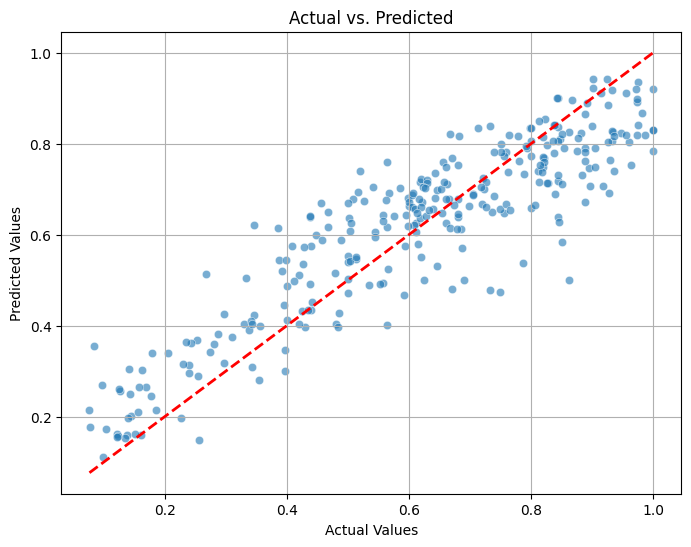

In [ ]:
#Visualization of Actual vs Predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=results_df['Actual'], y=results_df['Predicted'], alpha=0.6)
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()],
         [results_df['Actual'].min(), results_df['Actual'].max()],
         color='red', linestyle='--', linewidth=2)  # Diagonale Linie
plt.title('Actual vs. Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

---
**Analysis**

▸ Most points sit reasonably close to the red line, which means the model is able to reproduce the real attendance levels fairly well.

▸ The fit is strongest in the normal range of matches (roughly 20%–80% attendance). That’s also where most of the data lives, so the model had more examples to learn from.

**Where does it struggle?**

▸ The model tends to **overpredict very low-attendance games** (below ~0.25). That makes sense as there aren’t many truly empty stadium cases in the dataset, so the model defaults toward “average”.

▸ It also **underpredicts near sell-outs** (above ~0.85). Again expected: high-capacity, fully packed matches (derbies, European cups) are rare, so the model plays it safe and pulls those predictions downward.

▸ Result: the model is biased toward the middle — it’s most accurate where the dataset is densest, and less accurate on extremes.


**Main Takeaways**

▸ Overall, the model captures the general shape of attendance well, but it smooths out the peaks and dips.

In [ ]:
df['PercentageAttendance'].describe()
df['PercentageAttendance'].value_counts(bins=10, normalize=True)

,proportion
"(0.627, 0.72]",0.149746
"(0.813, 0.907]",0.143824
"(0.534, 0.627]",0.142132
"(0.72, 0.813]",0.137056
"(0.907, 1.0]",0.106599
"(0.44, 0.534]",0.079526
"(0.347, 0.44]",0.076142
"(0.0655, 0.161]",0.065144
"(0.254, 0.347]",0.060914
"(0.161, 0.254]",0.038917


**Final Model Analysis & Key Limitations**

▸ **The dataset is narrow, not deep.**  
We have 822 matches from a single league, which means the model mostly learns “average match behaviour” rather than edge cases or club-specific dynamics.

▸ **Weather does not improve predictions.**  
The difference between models with and without weather is basically zero. SHAP confirms it: all weather features (temperature, rain, roof, etc.) sit near the bottom of the importance ranking.

▸ **Why weather ends up irrelevant here:**  
• Most Belgian stadiums are already near or above 60% capacity by default  
• Ticket sales happen before the forecast is known  
• Serious bad-weather matches are extremely rare in the dataset

▸ **Attendance is driven by structural + team quality factors.**  
Max Capacity is the strongest feature by a large margin, followed by home/away team ranking and basic match-time information.

▸ **The model struggles at the extremes.**  
It **overpredicts very low-attendance games** (almost no empty stadiums in the dataset)  
and **underpredicts near sell-outs** (true 100% occupancy events are rare).

▸ **Linear models fail, tree models succeed.**  
Linear regression variants plateau at ~0.24 R², while Random Forest and XGBoost jump to ~0.64–0.67.  
→ The relationship between features and attendance is clearly non-linear.

▸ **Missing variables explain most of what’s left unexplained.**  
Things like season-ticket holders, club reputation, derbies, pricing, marketing, or fan loyalty are not in the data, but in reality drive attendance heavily.

---

### **What this means**

The model is reliable for predicting *typical Pro League matches* (~50–85% attendance),  
but it won’t accurately forecast unusual games — packed derbies, freezing-rain fixtures, etc.  
It learns the “center of gravity” of Belgian football crowds, not the emotional spikes.

---

### **Where to go from here**

▸ Add more seasons → reduces imbalance  
▸ Add more leagues → improves generalisation  
▸ Add fanbase variables → captures club-specific behaviour  
▸ Add ticket pricing + promotions → explains demand shocks  
▸ Predict attendance *per club* instead of pooled league model